In [1]:
import os
import numpy as np
import pandas as pd

# Define the path to the dataset file (Ensure it's uploaded to Colab)
file_path = '/content/Hurricane_irma.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# Load dataset into a pandas DataFrame
data = pd.read_csv(file_path)

# Check if required columns exist
if 'processed_data' not in data.columns or 'Binary_Class' not in data.columns:
    raise KeyError("The dataset must contain 'processed_data' and 'Binary_Class' columns.")

# Fill any missing values in the processed text column with empty strings
data['processed_data'] = data['processed_data'].fillna('').astype(str)

# Convert class labels from 'Non-Damage' and 'Damage' to 0 and 1 respectively
data['Binary_Class'] = data['Binary_Class'].map({'Non-Damage': 0, 'Damage': 1})

# Display the first few rows of the dataset
print("Dataset Sample:")
print(data.head())

# Show class distribution (helps understand data balance)
print("\nClass distribution:")
print(data['Binary_Class'].value_counts())

Dataset Sample:
                                          tweet_text  \
0  RT @MSN: Island of Barbuda 'literally under wa...   
1  RT @Reuters: Hurricane Irma threatens luxury T...   
2  RT @TheAnonJournal: BREAKING NEWS: Hurricane I...   
3  JUST IN: 11PM #Hurricane #Irma update. @ABC7Ne...   
4  RT @cnnbrk: Hurricane Irma destroys "upwards o...   

                                          Multiclass  Binary_Class  \
0  infrastructure_and_utility_damage | Infrastruc...             1   
1            other_relevant_information | Non-Damage             0   
2            other_relevant_information | Non-Damage             0   
3            other_relevant_information | Non-Damage             0   
4  infrastructure_and_utility_damage | Infrastruc...             1   

           Humanitarian_Class  \
0  other relevant information   
1  other relevant information   
2  other relevant information   
3  other relevant information   
4  other relevant information   

                           

In [2]:
from sklearn.model_selection import train_test_split

# Tokenize text by splitting into words (creates a list of words for each sentence)
sentences = [sentence.split() for sentence in data['processed_data']]
labels = data['Binary_Class'].values

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Print number of training and testing samples
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# Display an example of a tokenized sentence
print("Example tokenized sentence:", X_train[0])


Training samples: 3212, Testing samples: 804
Example tokenized sentence: ['hurricane', 'irma', 'gone', 'gt']


In [3]:
from gensim.models import Word2Vec
import numpy as np

# Train a Word2Vec model on tokenized sentences
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, sg=0)

# Get vocabulary size and embedding dimension
vocab_size = len(word2vec_model.wv.index_to_key)
embedding_dim = word2vec_model.vector_size

# Initialize an embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

# Create a dictionary mapping words to their index in the embedding matrix
word_index = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}

# Populate the embedding matrix with word vectors from Word2Vec
for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

# Print Word2Vec model details
print("Word2Vec model trained.")
print(f"Vocabulary Size: {vocab_size}")

Word2Vec model trained.
Vocabulary Size: 6553


In [4]:
import tensorflow as tf

# Convert sentences into sequences of word indices
X_train = [[word_index.get(word, 0) for word in sentence] for sentence in X_train]
X_test = [[word_index.get(word, 0) for word in sentence] for sentence in X_test]

# Pad sequences to a fixed length (ensures uniform input size)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=100)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=100)

# Print padded sequence example
print("Sequences converted and padded.")
print(f"Example sequence (first 10 values): {X_train[0][:10]}")

Sequences converted and padded.
Example sequence (first 10 values): [0 0 0 0 0 0 0 0 0 0]


In [5]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights (useful when classes are imbalanced)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights into a dictionary for Keras
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Print computed class weights
print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.5741866285305685, 1: 3.869879518072289}


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Define CNN model architecture
model = Sequential([
    # Embedding layer with pre-trained Word2Vec weights
    Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=X_train.shape[1], trainable=False),

    # First convolutional layer
    Conv1D(100, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.02),

    # Second convolutional layer
    Conv1D(150, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=3),
    BatchNormalization(),
    Dropout(0.02),

    # Third convolutional layer
    Conv1D(200, kernel_size=4, activation='relu'),
    MaxPooling1D(pool_size=4),
    BatchNormalization(),

    # Flatten layer
    Flatten(),

    # Fully connected (Dense) layer
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Output layer with a single neuron (binary classification)
    Dense(1, activation='sigmoid')
])

# Compile model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the CNN model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, class_weight=class_weights_dict, callbacks=[early_stopping])

# Print training completion message
print("Model training complete.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.5127 - loss: 1.4173 - val_accuracy: 0.4635 - val_loss: 2.3041
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5094 - loss: 0.9054 - val_accuracy: 0.8631 - val_loss: 0.5484
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5146 - loss: 0.7064 - val_accuracy: 0.7092 - val_loss: 0.5945
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5419 - loss: 0.6787 - val_accuracy: 0.4323 - val_loss: 0.7570
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4275 - loss: 0.7020 - val_accuracy: 0.6128 - val_loss: 0.6817
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4266 - loss: 0.7007 - val_accuracy: 0.1353 - val_loss: 0.8564
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4187 - loss: 0.7155 - val_accuracy: 0.1353 - val_loss: 0.8019
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3779 - loss: 0.6807 - val_accuracy: 0.1369 - val_

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step
Accuracy: 0.8619402985074627
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       696
           1       0.00      0.00      0.00       108

    accuracy                           0.86       804
   macro avg       0.43      0.50      0.46       804
weighted avg       0.75      0.86      0.80       804



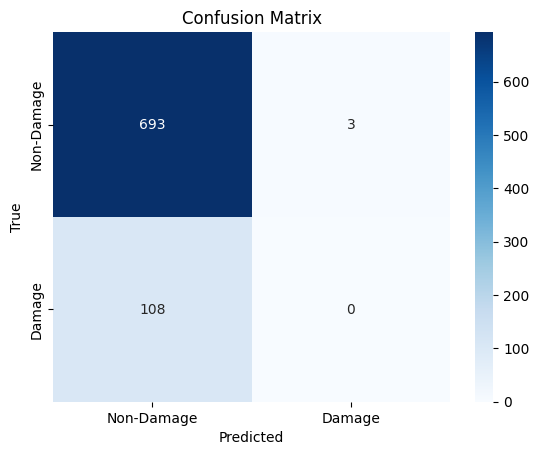

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Compute evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=1))
print("Recall:", recall_score(y_test, y_pred, zero_division=1))
print("F1 Score:", f1_score(y_test, y_pred, zero_division=1))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Damage', 'Damage'], yticklabels=['Non-Damage', 'Damage'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()